In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import network
from numba import jit, njit, double, int8, int64
from numba_progress import ProgressBar

# Aufgabe 4 
> Zielsetzung:
- Faltung bei konstanter Temperatur $T = 1$
- Auftragung der von Energie über Zeit (Monte-Carlo-Schritte)
- Struktur der resultierenden, gefalteten Zustände
- Abschätzung der Energiebarriere

> Durchführung der Monte-Carlo-Simulation: 

In [4]:
@njit(nogil=True)
def monte_carlo_const_temperature(protein, temperature, number_of_steps, progress_proxy):
    
    simulation = np.zeros(int(number_of_steps), dtype=double)
    for step in range(number_of_steps):
        simulation[step] = protein.energy
        protein.random_fold_step(temperature)
        progress_proxy.update(1)
    
    return simulation

steps = 1e7
temperature = 1

p = network.create_protein(interaction_type='normal')
p2 = network.Protein(np.copy(p.chain), np.copy(p.J))

with ProgressBar(total=2*steps) as progress:
    arr = monte_carlo_const_temperature(p, temperature, steps, progress)
    arr2 = monte_carlo_const_temperature(p2, temperature, steps, progress)


  0%|          | 0/20000000.0 [00:00<?, ?it/s]

> Auffinden und Mittelung der Energiebarrieren + Auftragung:

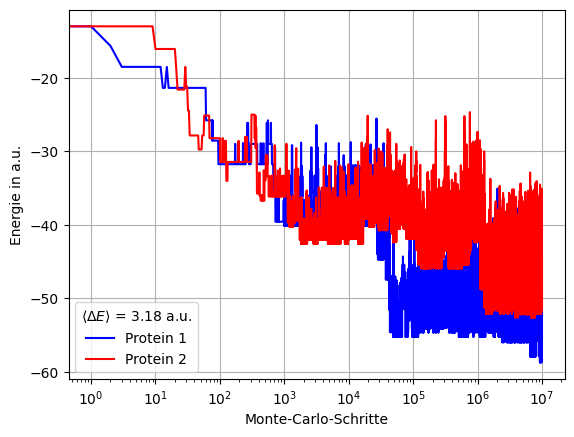

In [5]:
@jit((double[:])(int64, double[:]))
def energyBounds(number_of_steps, simulation):

    energy = np.zeros(number_of_steps, dtype=double)
    min_energy = 0
    last_energy = 0
    threshold = 0.3
    last_peak = False
    
    for i in range(number_of_steps):
        current_energy = simulation[i]
        
        if current_energy <= min_energy-1:
            if last_peak:
                energy[i] = abs(last_energy - min_energy)
                
                
            min_energy = current_energy
            last_peak = False
            
        if current_energy > min_energy:
            last_peak = True
            
        last_energy = current_energy
    energy = energy[energy > threshold]
    return energy[energy!=0] 

fig, ax = plt.subplots()

ax.set_xlabel('Monte-Carlo-Schritte')
ax.set_ylabel('Energie in a.u.')
ax.set_xscale('log')
plt.grid()

bounds = energyBounds(steps, arr)
bounds2 = energyBounds(steps, arr2)
bounds = np.concatenate((bounds, bounds2))

label =''
if len(bounds) > 0:
    label = r'$\langle \Delta E \rangle$ = '+str(round(np.mean(bounds), 2))+' a.u.'
ax.plot(np.arange(steps), arr, color='blue', label='Protein 1')
ax.plot(np.arange(steps), arr2, color='red', label='Protein 2')

if len(bounds) > 0:
    plt.legend(loc='lower left', title=label)

> Zeichnung der Proteinkette:

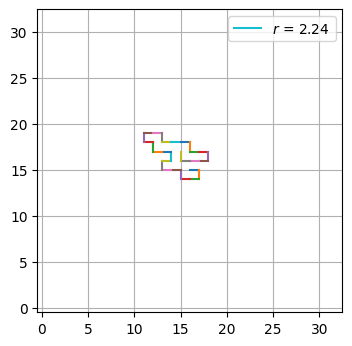

In [6]:
network.plot_protein(p)

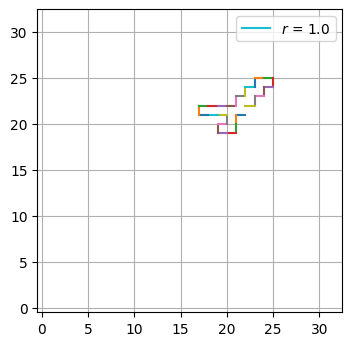

In [7]:
network.plot_protein(p2)